In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models, Input

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Load dataset
file_path = '/content/Dataset_Hardware_Impairments.csv'  # Replace with the path to your CSV file
data = pd.read_csv(file_path)

In [ ]:
# Split dataset into features and target
X = data.iloc[:, :-1].values  # 9 features
y = data.iloc[:, -1].values  # Target variable

In [ ]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Replace infinite values with NaN
X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in subtract
  new_unnormalized_variance -= correction**2 / new_sample_count


In [ ]:
# Reshape input data for CNN (add a channel dimension)
X_train = X_train.reshape(-1, X_train.shape[1], 1)
X_test = X_test.reshape(-1, X_test.shape[1], 1)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 5.8040 - mae: 2.1311 - val_loss: 1.8616 - val_mae: 1.1316
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7289 - mae: 1.0565 - val_loss: 1.5356 - val_mae: 1.0918
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3520 - mae: 0.9706 - val_loss: 1.2298 - val_mae: 0.9589
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0240 - mae: 0.8431 - val_loss: 0.8532 - val_mae: 0.7948
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6418 - mae: 0.6533 - val_loss: 0.5075 - val_mae: 0.5897
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4408 - mae: 0.5366 - val_loss: 0.3039 - val_mae: 0.4288
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3081 - mae: 0.4272 - val_loss: 0.2526 - val_mae: 0.4129
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2127 - mae: 0.3638 - val_loss: 0.1996 - val_mae: 0.3618
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.18

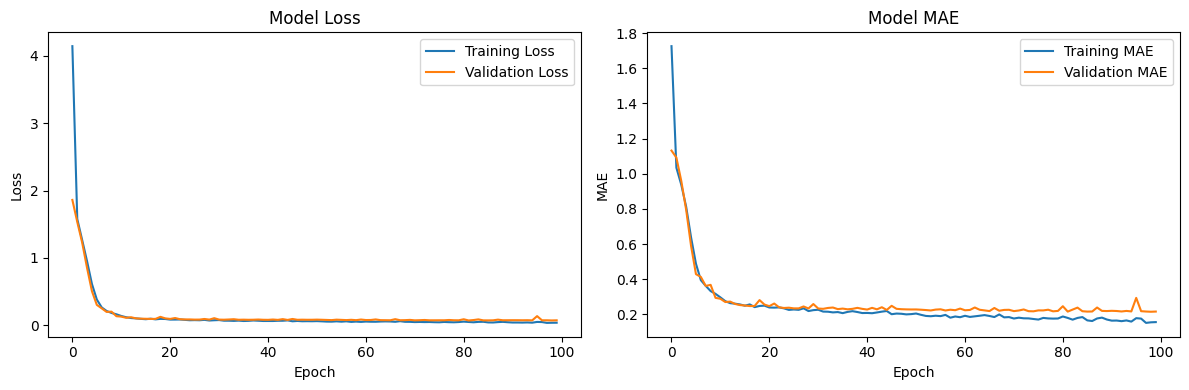

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models, Input, regularizers
import matplotlib.pyplot as plt

# Define the hybrid CNN-Transformer model
def build_model(input_shape):
    inputs = Input(shape=input_shape)

    # CNN Block
    x = layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Dropout(0.01)(x)

    # Preserve the sequence dimension for the Transformer
    x = layers.GlobalAveragePooling1D()(x)  # Remove this line

    # Transformer Block
    # Reshape the CNN output for the Attention layer
    # Assume x.shape[1] is the sequence length, x.shape[-1] is the feature dimension

    # Define the multi-head attention layer
    query = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.1))(x)  # (batch_size, sequence_length, features)
    key = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.1))(x)  # (batch_size, sequence_length, features)
    value = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.1))(x)  # (batch_size, sequence_length, features)
    attention_output = layers.Attention()([query, key, value])
    # Now you can use GlobalAveragePooling1D after the Attention layer
    # x = layers.GlobalAveragePooling1D()(attention_output)

    # Combine outputs (if needed)
    # combined = layers.Concatenate()([x, transformer_output])  # Remove or adapt if necessary

    dense_output = layers.Dense(128, activation='relu')(x)
    final_output = layers.Dense(1)(dense_output)  # Regression output

    model = models.Model(inputs, final_output)
    return model


# Assuming you have X_train, y_train, X_test, y_test defined
# Build the model
input_shape = (X_train.shape[1], 1)  # Assuming your input data has shape (timesteps, features)
model = build_model(input_shape)

# Compile the model
# For regression, 'accuracy' is not typically used. We'll use 'mae' instead
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Function to handle NaN values in data
def handle_nan(data):
    # Replace NaN with 0 (or other suitable value)
    return np.nan_to_num(data, nan=0.0)

# Preprocess data to handle NaNs
X_train = handle_nan(X_train)
y_train = handle_nan(y_train)
X_test = handle_nan(X_test)
y_test = handle_nan(y_test)

# Train the model (replace with your training data and parameters)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)  # Store training history

# Evaluate the model and print MAE and loss
loss, mae = model.evaluate(X_test, y_test, verbose=0)  # verbose=0 to suppress output
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

# Plot training history (loss and mae)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend() #add legend

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend() #add legend

plt.tight_layout()
plt.show()

